Датасет: UCI Machine Learning  
Шаги:  
- Exploratary Data Analisis
- Feature Engineering
- Feature Selection  
- Validation
- Model Selection

Описание датасета по ссылке:  
https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Данная задача multilabel multiclass classification, попробуем следующие подходы:
- Свесем задачку к binary classification
- Сведем задачу к multilabel binary classification
- Обучим множество multiclass/binary classification моделей


Идеи:  


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

--2021-08-03 17:58:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346695 (339K) [application/x-httpd-php]
Saving to: ‘drug_consumption.data.1’

drug_consumption.da 100%[===================>] 338.57K  --.-KB/s    in 0.05s   

2021-08-03 17:58:03 (6.82 MB/s) - ‘drug_consumption.data.1’ saved [346695/346695]



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [ ]:
data.columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 
                'Extraversion', 'Open_to_exp', 'Agreeableness', 'Conscientiousness', 'Impulsive', 'Sens_seeing',
                
                'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 
                'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine',
                'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Fictition', 'VSA']
data.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Open_to_exp,Agreeableness,Conscientiousness,Impulsive,Sens_seeing,Alcohol,Amphet,Amyl,Benzos,Caffeine,Cannabis,Chocolate,Cocaine,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Fictition,VSA
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy import stats
from scipy.stats import t
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

# преобразуем данные в категориальные и упрощаем
data = data.astype('category')

for i in data.columns:
    data[i] = data[i].cat.codes

# создем датасет для binary classification
data_binary = data.copy()

data_binary.iloc[:, 12:] = (data.iloc[:, 12:] > 0).astype('int')

data_binary = data_binary.astype('category')

# Binary classification

In [ ]:
# Попробуем предсказать склонность к употреблению Ecstasy

X = data_binary.drop('Ecstasy', axis=1)
y = data_binary['Ecstasy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('доля употреблявших:', np.mean(data_binary['Ecstasy'].astype('int')))

доля употреблявших: 0.4583554376657825


In [ ]:
# knn
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)
print(classification_report(y_test, knn.predict(X_test), target_names=['Never Used', 'Used']))

              precision    recall  f1-score   support

  Never Used       0.68      0.76      0.72       307
        Used       0.67      0.58      0.62       259

    accuracy                           0.68       566
   macro avg       0.68      0.67      0.67       566
weighted avg       0.68      0.68      0.68       566



In [ ]:
# knn param
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 30)}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)
knn_grid.fit(X_train, y_train)
print(knn_grid.best_params_, knn_grid.best_score_)
print(classification_report(y_test, knn_grid.predict(X_test), target_names=['Never Used', 'Used']))

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.0s


{'knn__n_neighbors': 20} 0.8536985827860353
              precision    recall  f1-score   support

  Never Used       0.86      0.81      0.83       307
        Used       0.79      0.85      0.82       259

    accuracy                           0.83       566
   macro avg       0.82      0.83      0.82       566
weighted avg       0.83      0.83      0.83       566



[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:   12.9s finished


In [ ]:
# random forest
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17, max_depth=13)
forest.fit(X_train, y_train)
print(classification_report(y_test, forest.predict(X_test), target_names=['Never Used', 'Used']))

              precision    recall  f1-score   support

  Never Used       0.92      0.82      0.87       307
        Used       0.81      0.91      0.86       259

    accuracy                           0.86       566
   macro avg       0.86      0.87      0.86       566
weighted avg       0.87      0.86      0.86       566



In [ ]:
# random forest param
forest_params = {'max_depth': range(1,20),
                 'max_features': range(20,30)}

forest_grid = GridSearchCV(forest, forest_params,
                           cv=5, n_jobs=-1, verbose=True)
forest_grid.fit(X_train, y_train)
print(classification_report(y_test, forest_grid.predict(X_test), target_names=['Never Used', 'Used']))

Fitting 5 folds for each of 190 candidates, totalling 950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 950 out of 950 | elapsed:  4.9min finished


              precision    recall  f1-score   support

  Never Used       0.91      0.81      0.86       307
        Used       0.80      0.91      0.85       259

    accuracy                           0.85       566
   macro avg       0.86      0.86      0.85       566
weighted avg       0.86      0.85      0.85       566



In [ ]:
# catboost
categorical_features = data.columns[data.columns != 'Ecstasy']

estimator = CatBoostClassifier(
                    loss_function='Logloss',
                    eval_metric='Logloss',
                    random_seed=42,
                    depth=7,
                    learning_rate=0.01,
                    early_stopping_rounds=200)
    
estimator.fit(      X_train, y_train,
                    cat_features=categorical_features,
                    eval_set=(X_test, y_test),
                    verbose_eval=200
                    )
print(classification_report(y_test, estimator.predict(X_test), target_names=['Never Used', 'Used']))

0:	learn: 0.6827625	test: 0.6836797	best: 0.6836797 (0)	total: 61.7ms	remaining: 1m 1s
200:	learn: 0.2711499	test: 0.3405542	best: 0.3405542 (200)	total: 2.22s	remaining: 8.81s
400:	learn: 0.2150041	test: 0.3224809	best: 0.3224809 (400)	total: 4.61s	remaining: 6.89s
600:	learn: 0.1803916	test: 0.3170874	best: 0.3170729 (599)	total: 6.96s	remaining: 4.62s
800:	learn: 0.1504889	test: 0.3153921	best: 0.3153743 (799)	total: 9.41s	remaining: 2.34s
999:	learn: 0.1252433	test: 0.3138403	best: 0.3138403 (999)	total: 11.9s	remaining: 0us

bestTest = 0.3138402782
bestIteration = 999

              precision    recall  f1-score   support

  Never Used       0.90      0.85      0.87       307
        Used       0.83      0.89      0.86       259

    accuracy                           0.87       566
   macro avg       0.86      0.87      0.87       566
weighted avg       0.87      0.87      0.87       566



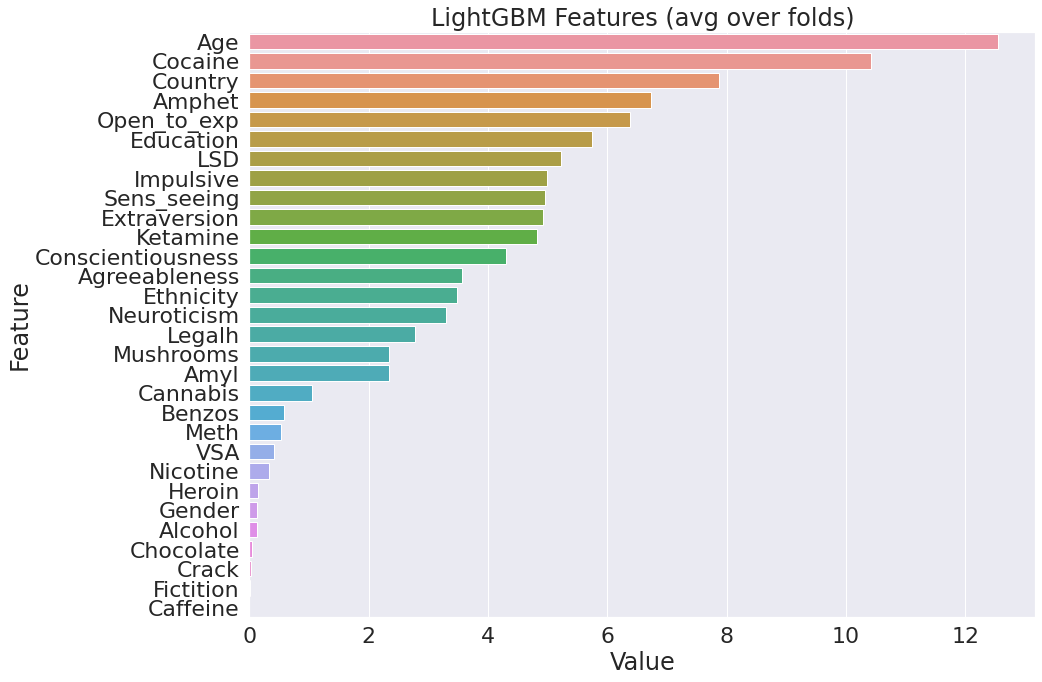

In [ ]:
# catboost feature importance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plotImp(model, X , num = 500):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=(15, 10))
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

plotImp(estimator, categorical_features) 

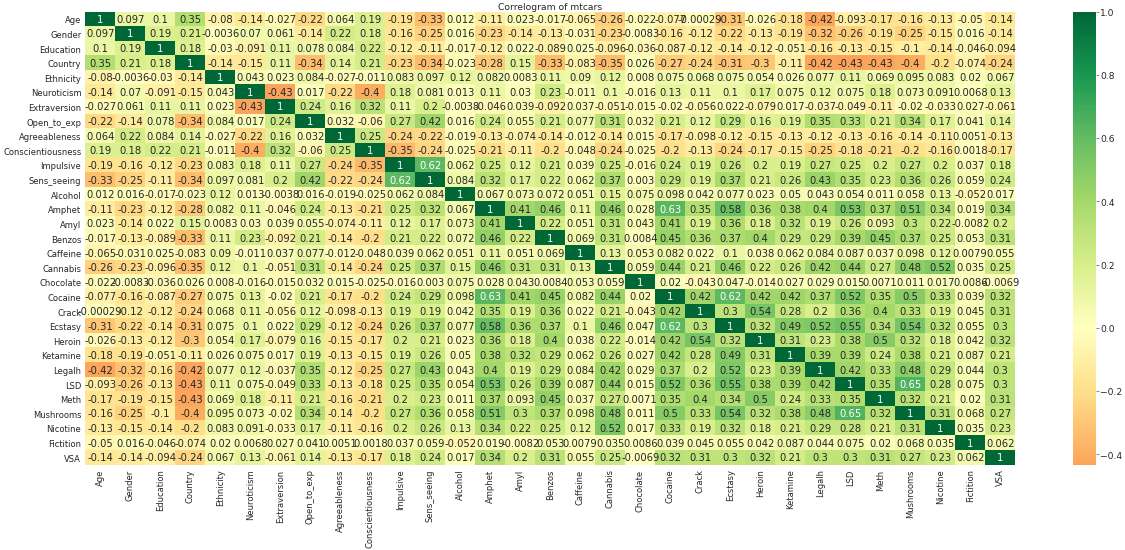

In [ ]:
# Plot
df = data_binary.astype('int')
plt.figure(figsize=(50,20), dpi= 30)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
# lightgbm
data_bin = data_binary.astype('int')

X = data_bin.drop('Ecstasy', axis=1)
y = data_bin['Ecstasy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

estimator = LGBMClassifier()
estimator.fit(X_train, y_train)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

params = {'boost': 'gbdt',
          'metric':'auc',
          'verbosity': 1,
          'objective': 'binary',
          'learning_rate':0.01,
          'num_leaves': 30}

model = lgb.train(params,
                    train_data,
                    num_boost_round=42000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=3000,
                    early_stopping_rounds = 200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's auc: 0.989132	valid_1's auc: 0.934225


In [ ]:
print(classification_report(y_test, np.round(model.predict(X_test)), target_names=['Never Used', 'Used']))

              precision    recall  f1-score   support

  Never Used       0.88      0.84      0.86       307
        Used       0.82      0.86      0.84       259

    accuracy                           0.85       566
   macro avg       0.85      0.85      0.85       566
weighted avg       0.85      0.85      0.85       566



In [ ]:
# logistic regression
X = data_binary.drop('Ecstasy', axis=1)
y = data_binary['Ecstasy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

logit_pred = logit.predict(X_test)
print(classification_report(y_test, logit_pred, target_names=['Never Used', 'Used']))

              precision    recall  f1-score   support

  Never Used       0.89      0.84      0.87       307
        Used       0.83      0.88      0.85       259

    accuracy                           0.86       566
   macro avg       0.86      0.86      0.86       566
weighted avg       0.86      0.86      0.86       566



In [ ]:
# так как датасет небольшой можно перебором проверить 
# оптимально количество признаков для обучения
from mlxtend.feature_selection import SequentialFeatureSelector

for i in range(26, 31):
    max_k_features = 0
    counter = 0
    selector = SequentialFeatureSelector(logit, scoring='f1', 
                                     verbose=False, k_features=i, forward=True, n_jobs=-1)
    selector.fit(X_train, y_train)
    log = LogisticRegression(n_jobs=-1, random_state=17)
    log.fit(selector.transform(X_train), y_train)

    log_pred = log.predict(selector.transform(X_test))
    f1 = f1_score(y_test, log_pred)
    if f1 > counter:
        counter = f1
        max_k_features = i
    
    print('k_features: ', i, f1)

k_features:  26 0.8434622467771639
k_features:  27 0.8497217068645639
k_features:  28 0.8518518518518519
k_features:  29 0.8438661710037175
k_features:  30 0.8523364485981308


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.linspace(0.05, 0.2, 1000)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_train, y_train)

logit_searcher_pred = logit_searcher.predict(X_test)
print(classification_report(y_test, logit_searcher_pred, target_names=['Never Used', 'Used']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

  Never Used       0.90      0.86      0.88       307
        Used       0.84      0.88      0.86       259

    accuracy                           0.87       566
   macro avg       0.87      0.87      0.87       566
weighted avg       0.87      0.87      0.87       566



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished
